- Andrea De Vita
- Enrico Lupi

-----------------------

# Using Latency-Encoded Spiking Neural Network for CMS Muon Chamber Denoising

In [1]:
# import event simulation files
import sys
sys.path.insert(0, './DataGeneration')
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryConfusionMatrix

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

The Compact Muon Solenoid (CMS) detector at LHC employs a sophisticated trigger system to efficiently select relevant events, reducing the rate by a factor of approximately $10^6$. Current trigger systems, developed over twenty years ago, can be boosted by recent advancements in technology, particularly in the realm of machine learning. \
This is especially true for the Muon Chamber Detector, whose trigger algorithm grows exponentially with the number of hits registered: with the increasing noise expected at HL-LHC, the number of spatial- and time-coherent signals is due to rise significantly, rendering this approach too computationally demanding. ANNs can thus be used to perform a first noise rejection and pattern recognition on clusters of compatible hits, followed by a standard analytical algorithm to evaluate other track parameters.

In this paper we tackle this task with an innovative approach: the implementation of spiking neural networks, a class of artificial neural networks that more closely mimics biological neural networks. They provide several advantages over the traditional models, including energy-efficient data representation, low power consumption, high execution speeds and an "event driven" data processing that natively incorporates time information.

We will investigate three different tasks:
1. The first analysis performed, **Chamber Classification**, is a proof of concept for the applicability of a SNN on our dataset. It consists in the classification of events into either "signal" or "background", depending on whether it contains genuine muon hits or only noisy hits respectively.
2. The second is the **Cell-by-Cell Classification**, where the previous classification is done on a singular cell basis for each one inside the chamber. 
3. The third task, **Online Denoising**, extends the previous one by differentiating true events from noise also for each time step across the entire temporal axis, accurately reconstructing the temporal evolution of the event.

## SNN: Basic Principles

A SNN can implement the same architectures as ordinary NNs: the key difference lies in the neuron model. Each neuron is characterised by an internal degree of freedom called the membrane potential *U(t)*, whose value changes over time. If it surpasses a certain threshold, it resets and the neuron emits an output spike. 

The first model for the temporal dynamics was proposed by Lapique in 1907 and follows the same laws of a low pass RC circuit. If we solve its differential equation, discretise the time and relax a bit the physical assumptions, we obtain the expression for the simplest neuron model, the Leaky Fire-and-Integrate (LIF)
\begin{equation}
    U[t] = \beta U[t-1] + WX[t] - S_{out}[t-1] \theta.
\end{equation}

$\beta$ is the parameter that governs the exponential decay of the membrane. $WX[t]$ is the input, and in a complete network with multiple neurons $W$ would be the weight matrix (containing also the bias) and $X$ the input vector. Lastly, we have the reset term: $\theta$ is the threshold value for the membrane while $ S_{out}$ is equal to 1 if the neuron generates a spike and 0 otherwise. $W$ and, optionally, $\beta$ and $\theta$, are the learnable parameters.

![pipeline](Images/LIF_model.png)

A slightly more complex but more biologically sound model is the Synaptic one. A spike will result in the gradual release of neurotransmitters from the pre-synaptic neuron to the post-synaptic neuron: this means that also the current, i.e. the input term, has a temporal dynamic, which we can assume to be a very fast increase followed by a relatively slow exponential decay. This is modeled with the following pair of equations:
\begin{equation}
    I_{syn}[t] = \alpha I_{syn}[t-1]  + WX[t],
\end{equation}

\begin{equation}
     U[t] = \beta U[t-1] +  I_{syn}[t] - S_{out}[t-1] \theta.
\end{equation}
Like $\beta$, the current decay rate $\alpha$ can also optionally be set as a learnable parameter. 

## Processing Pipeline
Here is how the end-to-end processing pipeline for the classification or denoising of the data is structured.
First the dataset is generated by simulating a simplified detector, and later encoded into a spike train which is fed into the SNN. The resulting output spike train is used to compute the loss function and the SNN is trained by descending along its gradient.


![pipeline](Images/pipeline.jpg)

## Signals and Preprocessing
The CMS muon chambers consist of three superlayers of drift tube detectors. Each superlayer comprises four layers,
each containing 50 cells, resulting in a total of 200 cells per superlayer.

![pipeline](Images/DT_CMS_bis.png)


We will study a simplified scenario, simulating events taken in a 4x4 cell muon chamber. Data is generated using a simulation script: the initial position and trajectory angle of the muon are selected randomly, and later the position at which the muon interacts with the detector (and thus also the timing of the hits) are computed. To simulate cell inefficiency, at most one hit can be deleted with a probability of 0.2. The probability that these events are contaminated with noise is equal to a tunable parameter, $noise\_frac$; if noise is present, from one up to four random cells present a "ghost" hit. Noise is generated with a trapezoid time distribution based on the arrival time of the muon. It is possible to generated events containing only noise: the ratio of these events over the total in a given dataset is a second tunable parameter called $bkg\_frac$.

In [3]:
n_evt = 100000
n_evt_test = 10000
n_evt_val = 10000

evt_arr,      muon_list,      max_n      = ge.generate_noisy_evts(n_evt,      noise_frac=0.5, bkg_frac=0.3)
evt_arr_test, muon_list_test, max_n_test = ge.generate_noisy_evts(n_evt_test, noise_frac=0.5, bkg_frac=0.3)
evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 10000/10000 [00:15<00:00, 657.26it/s]


Here is an example of a clean true event (the only hits registered are due to a muon passing through the chamber):

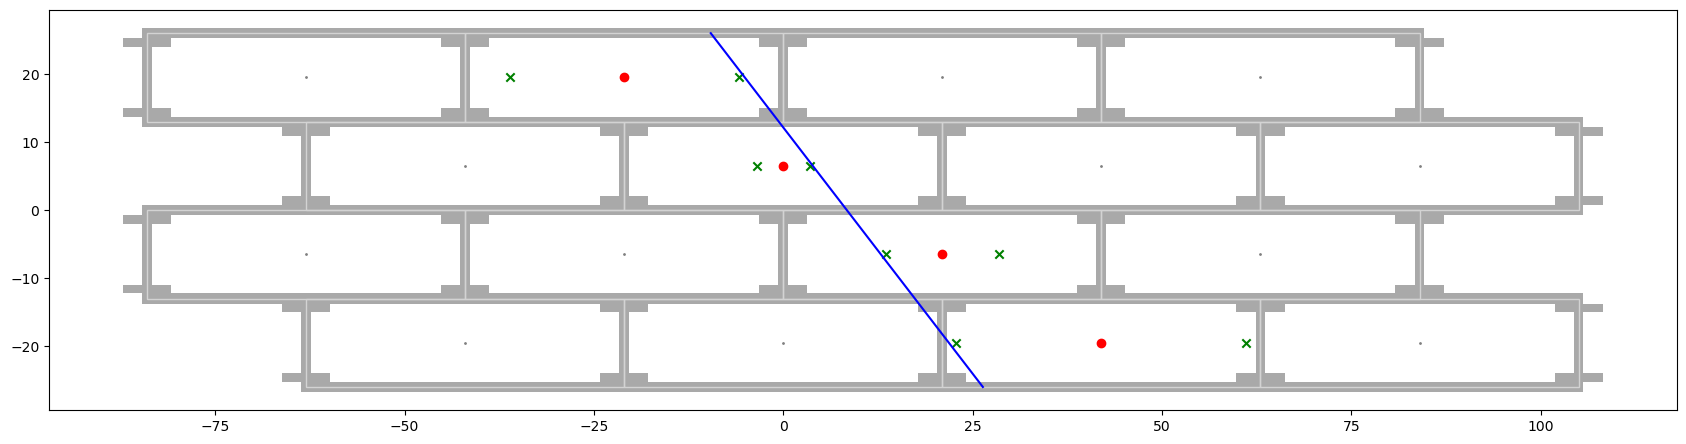

In [4]:
pe.plot_event(evt_arr[evt_arr['n_true_hits']==evt_arr['n_hits']][1])

To handle the generated data more easily, we will convert each event to a numpy array of fixed size, where each row will contain some information about a specific hit inside the event:

In [7]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr      = convert_to(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
mu_arr_test = convert_to(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

### Spike Train

The last step is to create for each input event a spiketrain to feed into the SNN. \
There are many possible encodings to choose from, but as our objective is to use this network inside the online trigger system we decided on latency encoding. The spike generator constructs a spike train of 40 bx, where each time slice consists in a 4x4 matrix whose elements correspond to the cells of the detector. The spike train contains only binary values, with a '1' designating a spike. Since each spike corresponds to a hit, its spatial position depends on the hit cell, while its timing corresponds to the difference between drift time and a time reference. The time is discretised in units of "BX" (bunch crossing), equal to 25 ns.

We implement the function in a more general way, allowing the input spikes to optionally be similar to the current in a Synaptic model neuron: it is not a Dirac Delta but an instantaneous increase followed by a relatively slow exponential decay. This means that spikes are no more binary values but fractionary values are allowed; moreover, inputs coming from multiple signal sum with each other, which may results in values larger than 1. It is not an orthodox encoding scheme, but this is needed in order to implement convolutional networks, otherwise the input would be too temporally sparse.

In [8]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True, pad=0, alpha=None):

    if alpha == None:
        spike_data = torch.zeros(size=(num_step+pad, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    else:
        t = torch.arange(0, pad)
        exp_tail =  np.exp(-alpha * t)
        spike_data = torch.zeros(size=(num_step+pad, batch_size, 1, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
        
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                if alpha == None:
                    spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
                else:
                    spike_data[bx-t0+ps.bx_oot:bx-t0+ps.bx_oot+pad, n_batch, 0, layer-1, wire-1] += exp_tail
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step+pad, batch_size, -1)
                
    return spike_data    

Let's see an example of spiketrain:

In [9]:
def train_visualization(input_train, axs, title):
    input_train = torch.transpose(input_train,0,1)
    # Plot for input_train
    plt.xticks(np.arange(0,41), labels=np.arange(1,42))
    plt.xticks(np.arange(0.5,41.5), minor=True)
    plt.yticks(np.arange(0,16), labels=np.arange(1,17))
    plt.yticks(np.arange(0.5,16.5), minor=True)
    axs.imshow(input_train, cmap='binary', interpolation='nearest')
    axs.set_title(title)
    axs.set_xlabel('Timestep')
    axs.set_ylabel('Neurons')
    plt.grid(which='minor', linestyle='--')


def plot_spiketrains(trains, titles):
    n = len(titles)
    fig, axs = plt.subplots(1, n, figsize=(12, 6))
    if n==1:
        train_visualization(trains, axs, titles[0])
    else:
        for i in range(n):
            train_visualization(trains[i], axs[i], titles[i])
    # Adjust layout for better spacing
    plt.tight_layout()
    # Show the plot
    plt.show()    

tensor([[  1.0000,   4.0000, 508.0000, 500.5667,   1.0000],
        [  4.0000,   4.0000, 502.0000, 500.5667,   1.0000],
        [  3.0000,   4.0000, 514.0000, 500.5667,   1.0000],
        [  2.0000,   4.0000, 504.0000, 500.5667,   1.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


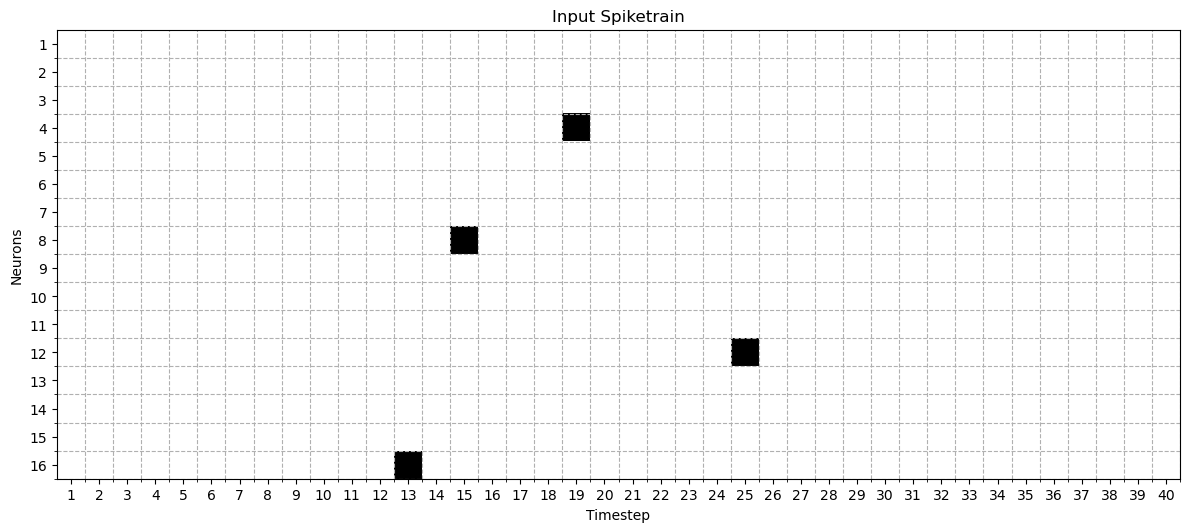

In [73]:
i = 1
print(mu_arr[i])
ex_spike = custom_spikegen(mu_arr[i:i+1,], 40, 2, True)
plot_spiketrains(ex_spike[:,0,:], ['Input Spiketrain',])

### Targets Generation

Depending on the type of classification we want, we need to define different types of targets for the network to learn.

For the *Chamber Calssification* we simply want to classify each event as "signal" (a muon has actually passed) or "background" (no muon but only noise), so the target will be an array of binary values, respectively 1 and 0.

In [11]:
def gen_target_chamber(muon_list):
    target = np.zeros(shape=(len(muon_list)))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            if hit['signal'] == True:
                target[i] = 1
                break

    return torch.tensor(target, dtype=torch.long)

For *Cell-by-Cell Classificaion* we try to discriminate between signal and noise for each cell inside the chamber. In this case, the target will be a 4x4 binary matrix (or vector with 16 elements) with 1 if a muon passed through the corresponding cell and 0 otherwise (noise or no hit at all). 

In [12]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

Finally, let us see tha case of *Online Denoising*: the target will be a spike train similar to the one produced by the input, but where all the hits due to noise are eliminated. The generation of the actual spiketrain will be handled inside the training loop.

In [13]:
def filter_noise(muon_list):
    target_list=[]
    
    for event in muon_list:
        target_event=[]
        for hit in event:
            
            if hit["signal"] == True:
                target_event.append(hit)
        
        target_list.append(target_event)
        
    return target_list

def gen_target_timing(muon_list, size, target_dtype, features):
    filtered_list = filter_noise(muon_list)
    return convert_to(filtered_list, size, target_dtype, features)
    

### Custom Dataset and Dataloader

To easily work in the PyTorch framework we will define custom datasets and dataloaders. Each item in the dataset will be a tuple containing the array of hits and the respective target.

In [14]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

## Learning Framework

Now it is time to define the network proper. We will implement six general network models:

1. Fully Connected Net with one hidden layer, using LIF neurons
2. Fully Connected Net with one hidden layer, using Synaptic neurons
3. Fully Connected Net with three hidden layers, using Synaptic neurons
4. Convolutional Net with two convolutional layers followed by one fully connected layer, using LIF neurons
5. Convolutional Net with two convolutional layers followed by two fully connected layers, using LIF neurons
6. Convolutional Net with three convolutional layers and a Max Pool followed by one fully connected layer, using LIF neurons

All the nets have 16 neurons in the input layer, corresponding to the 16 cells of the chamber. For the output layer, we use 2 neurons for the whole-chamber classification (one for the "signal" class and the other for "background"), 32 neurons for the cell-by-cell classification (two neurons for each cell) and finally either 16 or 32 neurons for the online denoising, depending on the loss function adopted (described later). \
We can test different values for the number of neurons in the hidden fully connected layers and various depths, kernel sizes and strides for the convolutional layers.

The neuron parameters $\alpha$, $\beta$ and $\theta$ can either be fixed from the start or learnable. The decay parameter is initialised at $\beta=0.8$ to match the theoretical expectation of having a decay time of ~16 BX.  

In [15]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [16]:
class Net_Syn_1L(nn.Module):
    """FCN with 1 hidden layer and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [17]:
class Net_Syn_3L(nn.Module):
    """FCN with 3 hidden layers and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [18]:
class CNN_LIF_2CL(nn.Module):
    """Net with 2 Convolutional Layers, 1 FC Layer and LIF neurons."""

    def __init__(self, filters, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.num_inputs = input_feat          # number of input neurons
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.filters = filters                # number of filters
    
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                   learn_beta=learnable, learn_threshold=learnable)
                
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                   learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
    def forward(self, x):

        # Initalize membrane potential
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
    
            cur2 = self.fc_out(spk2c.view(spk2c.size(0), -1))
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [ ]:
class CNN_LIF_2CL_2FC(nn.Module):
    """Net with 2 Convolutional Layers, 2 FC Layer and LIF neurons."""

    def __init__(self, filters, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.num_inputs = input_feat          # number of input neurons
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.filters = filters                # number of filters
    
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_in = nn.Linear(in_features=self.filters[1]*self.num_inputs, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):

            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
    
            cur1 = self.fc_in(spk2c.view(spk2c.size(0), -1))
            spk1, mem1 = self.lif_in(cur1, mem1)
        
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
            
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [19]:
class CNN_LIF_3CL_MP(nn.Module):
    """Net with 3 Convolutional Layers, 1 Max Pool Layer, 1 FC Layer and LIF neurons."""

    def __init__(self, filters, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.num_inputs = input_feat          # number of input neurons
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.filters = filters                # number of filters
    
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.conv1 = nn.Conv2d(1, self.filters[0], kernel_size=3, stride=1, padding=1)
        self.lif_conv1 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv2 = nn.Conv2d(self.filters[0], self.filters[1], kernel_size=3, stride=1, padding=1)
        self.lif_conv2 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.conv3 = nn.Conv2d(self.filters[1], self.filters[2], kernel_size=3, stride=1, padding=1)
        self.lif_conv3 = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold=0.9, learn_threshold=True,learn_beta=True)
        
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
            
        self.fc_out = nn.Linear(in_features=self.filters[2]*self.num_inputs//4, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta,spike_grad=spike_grad,threshold = 0.9,learn_threshold=True,learn_beta=True)
        
    def forward(self, x):

        # Initalize membrane potential
        mem2 = self.lif_out.init_leaky()
        
        mem1c = self.lif_conv1.init_leaky()
        mem2c = self.lif_conv2.init_leaky()
        mem3c = self.lif_conv3.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        test = []
        # Loop over 
        for step in range(self.timesteps):
            
            convol1 = self.conv1(x[step])
            spk1c, mem1c = self.lif_conv1(convol1, mem1c)
            
            convol2 = self.conv2(spk1c)
            spk2c, mem2c = self.lif_conv2(convol2, mem2c)
            
            convol3 = self.conv3(spk2c)
            spk3c, mem3c = self.lif_conv3(convol3, mem3c)
            
            pooled = self.maxpool(spk3c)
            
            cur2 = self.fc_out(pooled.view(pooled.size(0), -1))
            spk2, mem2 = self.lif_out(cur2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)
        return  torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

### Loss Functions
For the classification tasks, as the basis for the loss function we will use the *ce_count_loss* (or Cross Entropy Spike Count Loss, CESCL) as defined by *snntorch*: 
>The spikes at each time step [num_steps x batch_size x num_outputs] are accumulated and then passed through the Cross Entropy Loss function. This criterion combines log_softmax and NLLLoss in a single function. The Cross Entropy Loss encourages the correct class to fire at all time steps, and aims to suppress incorrect classes from firing.

\begin{equation}
    P_i = \frac{e^{ \sum_{t=1}^{40} S_{out}^i[t] }}{\sum_{j=0}^{1} e^{ \sum_{t=1}^{40} S_{out}^j[t] } }, 
\end{equation}


\begin{equation}
\mathcal{L} = - \sum_{i = 0}^{1} \hat{y}_i \log(P_i),
\;\;\;\;\;\;\;
    \hat{y}_i = 
        \begin{cases}
            1 \text{, if $i$ is the index of the correct class}\\
            0 \text{, otherwise} \\
        \end{cases}.
\end{equation}

This loss works well when classifying the whole chamber, but needs to be tweaked when dealing with per-cell classification. For the latter, we need to define a custom loss that computes the *ce_count_loss* for each cell (corresponding to a pair of neurons) and sums the total together:
\begin{equation}
    \mathcal{L} = - \sum_{n=1}^{16} \sum_{i = 0}^{1} \hat{y}_{i}^{n} \log(P_{i}^{n}),
\end{equation}
using $n$ as the cell index.

In [20]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

In [21]:
class Truncated_Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, window):
        super(Truncated_Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.window = window

    def forward(self, inputs, targets):
        n_groups = inputs.shape[-1]//self.n_classes # n. of independent classification groups
        t_limit = inputs.shape[0] - self.window
        loss = 0
        for i in range(n_groups):
            for t in range(t_limit):
                loss += self.loss(inputs[t:t+self.window, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[t, :, i])
        return loss

For the online denoising, on the other hand, the simplest implementation is a MSE loss that compares the output spike train with the spike train produced by the denoised target. In order to avoid all outputs to go to zero, considering a signal as noise (false negative) will be more heavily penalised:

\begin{equation}
    \mathcal{L} = \sum_{t=1}^{40} \sum_{n=1}^{16} w(S_{out}^{n}[t], T^{n}[t]) \cdot (S_{out}^{n}[t] - T^{n}[t])^2,
\end{equation}

In [22]:
class Weighted_MSE_loss(nn.Module):
    def __init__(self, weights, reduction):
        super(Weighted_MSE_loss, self).__init__()
        self.weights = weights
        self.reduction = reduction

    def forward(self, output, targets):
        diff = output - targets
        diff[diff > 0] *= self.weights[0]
        diff[diff < 0] *= self.weights[1]

        if self.reduction == 'mean':
            return torch.mean(diff ** 2)
        else:
            return torch.sum(diff ** 2)


A more refined approach consists of computing the loss using the membrane potentials at each time step, either computing the cross entropy on two different output neurons per cell (Cross Entropy Membrane Rate Loss):

\begin{equation}
    P_{i}^{n}[t] = \frac{e^{ U^{i,n}[t] }}{\sum_{j=0}^{1} e^{ U^{j,n}[t] } },
\end{equation}

\begin{equation}
    \mathcal{L} = - \sum_{t=1}^{40} \sum_{n=1}^{16} \sum_{i=0}^{1} \hat{y}_{i}^{n}[t] \log(P_{i}^{n}[t]),
\end{equation}

or computing the Bbinary cross entropy on a single neuron (Binary Cross Entropy Membrane Rate Loss):

\begin{equation}
    P^{n}[t] = \frac{1}{1 + e^{-U^{n}[t]} },
\end{equation}

\begin{equation}
    \mathcal{L} = - \sum_{t=1}^{40} \sum_{n=1}^{16} \left( \dot{y}^{n}[t] \log(P^{n}[t]) + (1 - \dot{y}^{n}[t])\log(1 - P^{n}[t]) \right), 
    \;\;\;\;\;\;\;
    \dot{y} = 
        \begin{cases}
            1 \text{, if the correct class is "signal"} \\
            0 \text{, if the correct class is "background"} \\
        \end{cases}.
\end{equation}

In [23]:
class LossFunctions:
    def _prediction_check(self, spk_out):
        device = spk_out.device

        num_steps = spk_out.size(0)
        num_outputs = spk_out.size(-1)

        return device, num_steps, num_outputs

    def _population_code(self, spk_out, num_classes, num_outputs):
        """Count up spikes sequentially from output classes."""
        if not num_classes:
            raise Exception(
                "``num_classes`` must be specified if "
                "``population_code=True``."
            )
        if num_outputs % num_classes:
            raise Exception(
                f"``num_outputs {num_outputs} must be a factor "
                f"of num_classes {num_classes}."
            )
        device = spk_out.device
        pop_code = torch.zeros(tuple([spk_out.size(1)] + [num_classes])).to(
            device
        )
        for idx in range(num_classes):
            pop_code[:, idx] = (
                spk_out[
                    :,
                    :,
                    int(num_outputs * idx / num_classes) : int(
                        num_outputs * (idx + 1) / num_classes
                    ),
                ]
                .sum(-1)
                .sum(0)
            )
        return pop_code



class ce_mem_loss_timing(LossFunctions):
    """Cross Entropy Membrane Rate Loss.
    When called, the membrane potential values at each time step are
    sequentially passed through the Cross Entropy Loss function.
    This criterion combines log_softmax and NLLLoss in a single function.
    The losses are accumulated over time steps to give the final loss.
    The Cross Entropy Loss encourages the membrane potential of
    the correct class to increase in presence of a signal, while suppressing the
    membrane potential of incorrect classes. In absence of a signal, this
    trend is reversed.

    Example::

        import snntorch.functional as SF

        loss_fn = SF.ce_mem_loss_timing()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "ce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        loss_fn = nn.NLLLoss()

        log_p_y = log_softmax_fn(mem_out)
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(log_p_y[step], targets[step])

        return loss / num_steps
    
    
class bce_mem_loss_timing(LossFunctions):
    """Binary Cross Entropy Membrane Rate Loss.
    When called, the membrane potential values at each time step are
    sequentially passed through the Binary Cross Entropy with Logits
    Loss function. The losses are accumulated over time steps to give 
    the final loss. The Cross Entropy Loss encourages the membrane potential
    of the correct neuron to increase in the presence of a signal, while
    suppressing the membrane potential at other times.


    Example::

        import snntorch.functional as SF

        loss_fn = SF.bce_mem_loss_timing()
        loss = loss_fn(outputs, targets)

    :return: Loss
    :rtype: torch.Tensor (single element)

    """

    def __init__(self):
        self.__name__ = "bce_mem_loss_timing"

    def __call__(self, mem_out, targets):
        device, num_steps, _ = self._prediction_check(mem_out)
        loss_fn = nn.BCEWithLogitsLoss()
        
        loss = torch.zeros((1), dtype=torch.float, device=device)

        for step in range(num_steps):
            loss += loss_fn(mem_out[step], targets[step].float())

        return loss / num_steps

### Accuracy

We now define the accuracy functions based on the task. When dealing with cell-by-cell classification or online denoising, we can decide if we want an accuracy per single cell or a global accuracy for the whole event.

In [24]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0
    predicted = None

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (MSE loss)
    elif type == 'mse_timing':
        total = targets.numel()
        correct = (output == targets).sum().item()
        predicted = output

    # accuracy on the whole event for timing reconstruction
    # (MSE loss)
    elif type == 'mse_timing_per_evt':
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())
        predicted = output

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (CEMRL)
    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (CEMRL)
    elif type == "ce_timing_per_evt":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (BCEMRL)
    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (BCEMRL)
    elif type == "bce_timing_per_evt":
        batch_size = targets.size(1)
        total = batch_size
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (Truncated CESCL)
    elif type == 'cell_timing':
        window = 16 ####### HARDCODED WINDOW LENGTH!
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        predicted = torch.zeros(num_steps, batch_size, ps.NLAYERS*ps.NWIRES)
        for t in range(num_steps):
            _, predicted[t] = output[t:t+window].sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    #  accuracy on the whole event for timing reconstruction
    # (Truncated CESCL)
    elif type == 'cell_timing_per_evt':
        window = 16 ####### HARDCODED WINDOW LENGTH!
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        predicted = torch.zeros(num_steps, batch_size, ps.NLAYERS*ps.NWIRES)
        for t in range(num_steps):
            _, predicted[t] = output[t:t+window].sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[:,i] == targets[:,i]).all())


    return total, correct, predicted

This function computes mean loss, accuracy and optionally the confusion matrix on a whole dataset:

In [25]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, num_steps, pad,
                 batch_size, CM, timing, linearise, use_membrane, alpha):
    bcm = BinaryConfusionMatrix()
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        cm = torch.tensor([[0,0],[0,0]])
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise, pad, alpha)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr
            if CM:
                cm += bcm(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        if CM:
            cm = cm/cm.sum()

        return mean_loss, acc, cm

F1 score, defined as:

$
F_{1} = 2 \cfrac{precison \cdot recall}{precision + recall} 
$

In [26]:
def F1_score(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    f1 = 2*precision*recall/(precision+recall)
    if math.isnan(f1):
        f1 = 0

    return f1

### Training Method

In the training we leverage gradient descent through backpropagation, using Adam as the optimiser with parameters $\eta=5 \cdot 10^{-4}$, $\beta_1 = 0.9$ and $\beta_2 = 0.999$. Each network is trained for a total of 10 epochs.

To avoid the so-called "dead neuron problem", which arises due to the non-differentiability of the spikes, we employ the surrogate gradient method. In particular, we adopt a fast sigmoid:
\begin{equation}
    \frac{\partial \hat{S}}{\partial U} = \frac{1}{(1 + 25 |U|)^2}.
\end{equation}

In [27]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type,
              num_steps=40, pad=0,  batch_size=100, linearise=True, timing=False, use_membrane=False, alpha=None):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps, pad,
                                             batch_size, False, timing, linearise, use_membrane, alpha)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise, pad, alpha)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps, pad,
                                                 batch_size, False, timing, linearise, use_membrane, alpha)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

## Results

### Hyperparameters Optimization

The performances of the different networks were evaluated using a validation dataset of 10'000 simulated events, using the final loss function and the final accuracy values as comparative quantities.

The chamber and cell-by-cell classifications were tested using different type of hyperparameters, such as network depth, neuron model and its $\theta$, $\alpha$ and $\beta$ parameters.

Task 1:

| **Configuration** | **Loss** | **Acc. [\%]** | 
| :---------------- | :------: | :-----------: |
| Syn(100), $\alpha,\beta=0.8$, $\theta=0.9$ | 0.047 | 98.61 | 
| Lif(30)                                    | 0.051 | 98.18 |
| Syn(20,20,20)                              | 0.050 | 98.15 |
| Syn(20,20,20), $\alpha,\beta=0.8$ , $\theta=0.9$ | 0.061 | 97.80 | 
| Syn(100)                                         | 0.066 | 97.68 |
| Lif(100)                                         | 0.083 | 97.20 |
| Lif(100), $\beta=0.8$ , $\theta=0.9$             | 0.082 | 96.68 |
| Lif(30) , $\beta=0.8$ , $\theta=0.9$             | 0.116 | 95.61 |
| Lif(100) , $\beta=0.5$ , $\theta=0.9$            | 0.155 | 93.95 | 
| Lif(30) , $\beta=0.5$ , $\theta=0.9$             | 0.187 | 93.95 |

Task 2:

| **Configuration** | **Loss** | **Acc. Event [\%]** | **Acc. Cell [\%]** | 
| :---------------- | :------: | :-----------------: | :----------------: |
| Syn(100), $\alpha,\beta=0.8$, $\theta=0.9$ | 0.598 | 85.76 | 98.884 |
| Syn(30) | 0.607 | 85.6 | 98.888 |
| Syn(100) | 0.582 | 83.73 | 98.731 |
| Syn(20,20,20), $\alpha,\beta=0.8$,$\theta=0.9$ | 0.802 | 81.58 | 98.383 |
| Syn(30),$\alpha,\beta=0.5$, $\theta=0.9$ | 0.762 | 81.34 | 98.495 |
| Lif(100) | 0.725 | 81.23 | 98.493 |
| Lif(30) | 0.826 | 80.82 | 98.338 |
| Lif(100), $\beta=0.8$, $\theta=0.9$ | 0.75 | 76.28 | 98.888 |
| Syn(20,20,20) | 1.163 | 72.4 | 97.351 |
| Lif(30), $\beta=0.8$, $\theta=0.9$| 1.091 | 71.2 | 98.731 |
|  Lif(30), $\beta=0.5$, $\theta=0.9$ | 0.725 | 66.65 | 96.878 |
| Conv(100,40,16)+MP+FC(64) | 0.301 |  92.53 |  99.35 |
| Conv(40,16)+FC(256) | 0.363 |  91.47 | 99.24 |
|Conv(40,20)+FC(320,100) | 0.388 | 90.27 | 99.07 |



For the online denoising we test different loss functions instead of different network parameters.

Task 3:

| **Loss Function** | **Loss** | **Acc. Event [\%]** | **Acc. Cell [\%]** | 
| :---------------- | :------: | :-----------------: | :----------------: |
| Weighted MSE | 255.32 | 29.52 | 99.6 |
| CEMR  | 0.566 | 29.5 | 99.6 |
| BCEMR | 0.037 | 29.49 | 99.6 |

### Results on Test Set

The results on a test set of the optimal nets for each task are presented along with the respective F1 score. As the performances on the third task were almost the same, it was decided to use the network trained with BCEMR loss as a representative.

| **Loss Function** | **Loss** | **Acc. Event [\%]** | **Acc. Cell [\%]** | **F1 Score** |
| :---------------- | :------: | :-----------------: | :----------------: | :----------: |
| 1         | 0.055 | 97.31 | -     | 0.980  |
| 2         | 0.460 | 89.18 | 99.08 | 0.971  |
| 2 (Conv.) | 0.322 | 92.25 | 99.32 | 0.979  |
| 3         | 0.037 | 30.42 | 99.60 | 0.0006 |

Task 1:

![pipeline](Images/task1.png)

Task 2:

![pipeline](Images/task2.png)

Task 2 (Conv.):

![pipeline](Images/task2_conv.png)

Task 3:

![pipeline](Images/task3.png)

## Examples

### Chamber Classification

In [62]:
target      = gen_target_chamber(muon_list)
target_test = gen_target_chamber(muon_list_test)
target_val  = gen_target_chamber(muon_list_val)

100000it [00:01, 57561.25it/s]
10000it [00:00, 116934.61it/s]
10000it [00:00, 131552.99it/s]


In [63]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

In [66]:
num_inputs = 16
num_hidden = 100
num_output = 2
timesteps  = 40
learnable  = True
beta       = 0.8
threshold  = 1.0
alpha      = 0.8

net_1 = Net_Syn_1L(num_inputs, num_hidden, num_output, timesteps, learnable, beta, threshold, alpha).to(device)

In [31]:
loss_fn = SF.ce_count_loss()
accuracy_type = 'chamber'
optimizer = torch.optim.Adam(net_1.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 10

loss_hist, loss_val_hist, acc_val_hist = train_net(net_1,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, 0, batch_size,
                                                   True, False, False, None)

torch.save(net_1.state_dict(), "results/Optimal/net_1")

Validation Set Loss: 0.7551394110918045
Validation Set Accuracy: 58.47%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 0.7403599619865417 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 0.5091552138328552 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 0.3762863576412201 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 0.35248398780822754 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 0.3887198269367218 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 0.2659624218940735 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 0.12660177052021027 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 0.1560850739479065 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 0.12405957281589508 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 0.16571849584579468 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 0.10960579663515091 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 0.14014722406864166 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 0.07637204974889755 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 0.06815522909164429 

Epoch

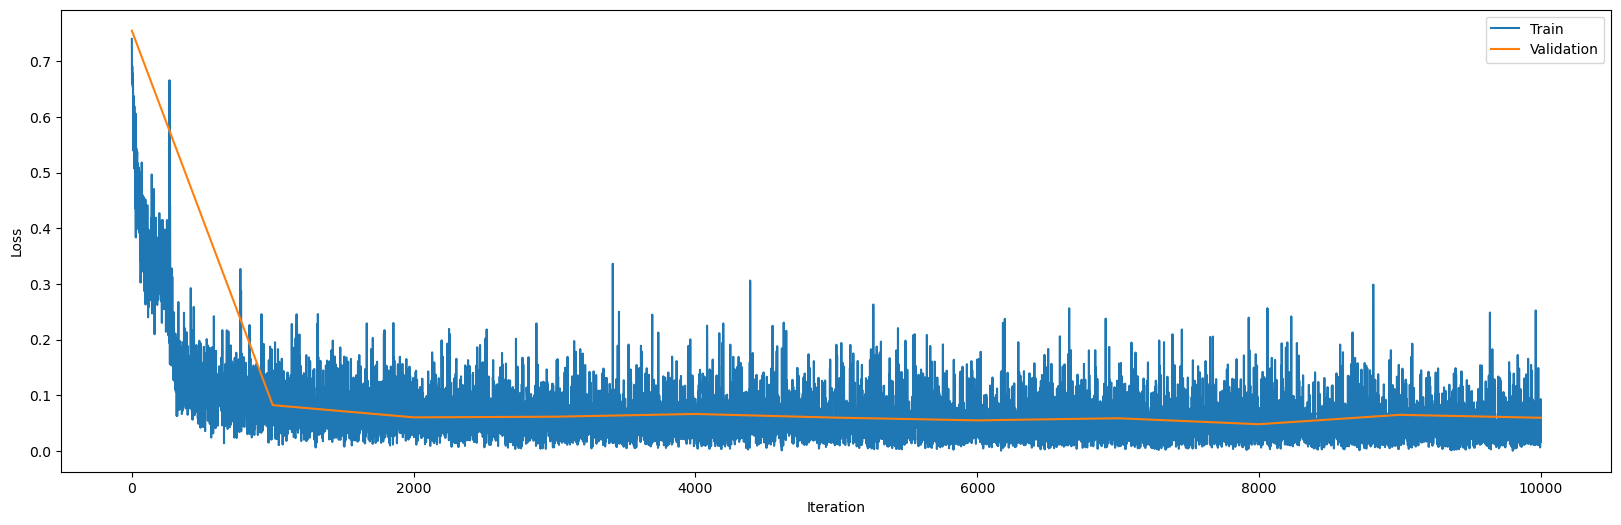

In [32]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

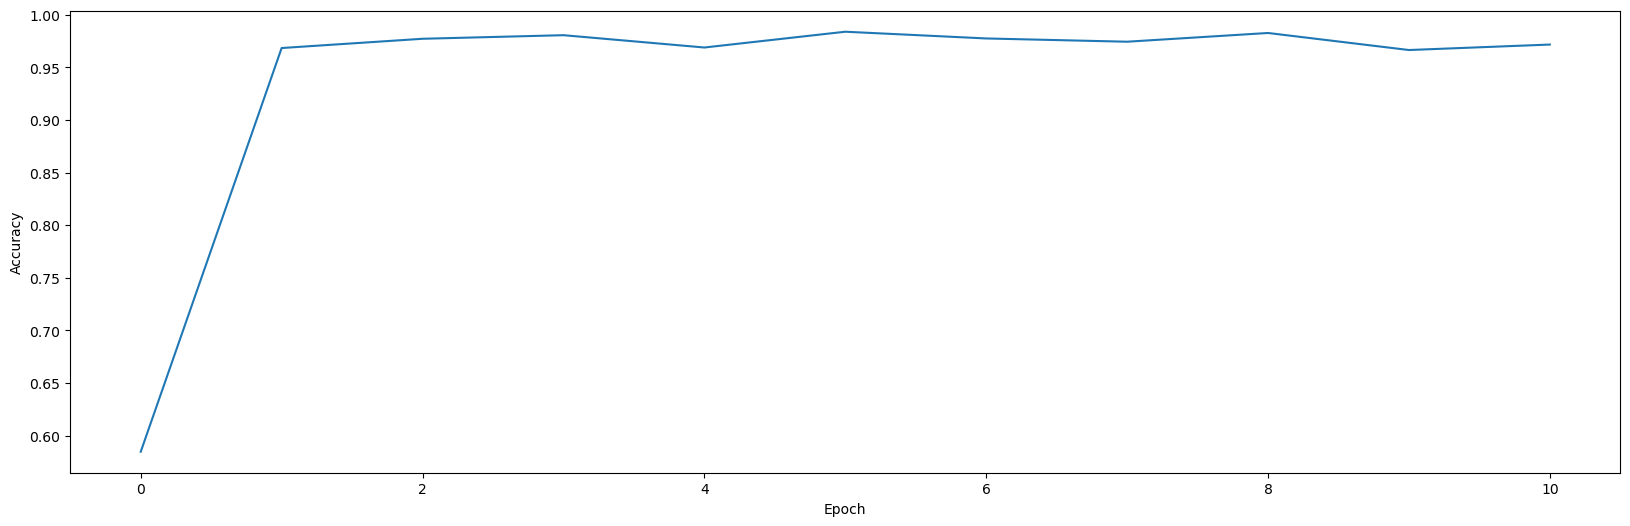

In [33]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Test Set Loss: 0.055392851699143646
Test Set Accuracy: 97.31%
F1 score: 0.9803921580314636


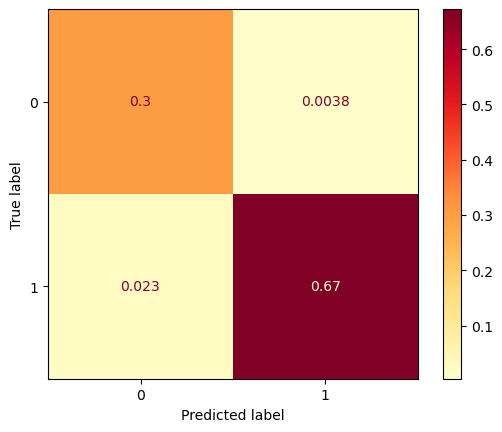

In [67]:
mean_loss_test, acc_test, cm = accuracy_set(net_1, test_loader, loss_fn, 'chamber', timesteps, 0,
                                            batch_size, True, False, True, False, None)
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

f1 = F1_score(cm)
print(f"F1 score: {f1}")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot(cmap='YlOrRd')


### Cell-by-Cell Classification

In [68]:
target      = gen_target_cell(muon_list, True)
target_test = gen_target_cell(muon_list_test, True)
target_val  = gen_target_cell(muon_list_val, True)

0it [00:00, ?it/s]

100000it [00:00, 105135.42it/s]
10000it [00:00, 73230.85it/s]
10000it [00:00, 74037.60it/s]


In [69]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

Fully connected:

In [70]:
num_inputs = 16
num_hidden = 100
num_output = 32
timesteps  = 40
learnable  = True
beta       = 0.8
threshold  = 1.0
alpha      = 0.8

net_2 = Net_Syn_1L(num_inputs, num_hidden, num_output, timesteps, learnable, beta, threshold, alpha).to(device)

In [38]:
loss_fn = Multi_loss(2, SF.ce_count_loss(), False)
accuracy_type = 'cell_per_evt'
optimizer = torch.optim.Adam(net_2.parameters(), lr=2e-3, betas=(0.9, 0.999))
num_epochs = 10

loss_hist, loss_val_hist, acc_val_hist = train_net(net_2,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, 0, batch_size,
                                                   True, False, False, None)

torch.save(net_2.state_dict(), "results/Optimal/net_2")

Validation Set Loss: 72.17378288269043
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 73.45489501953125 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 7.253922462463379 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 5.5903706550598145 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 4.372439861297607 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 2.7188830375671387 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 2.220179796218872 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 2.3102121353149414 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 1.768273949623108 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 1.6919227838516235 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.4917559623718262 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.6597027778625488 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 1.4183729887008667 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 1.346101999282837 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 1.8844846487045288 

Epoch: 1
Batch: 700
I

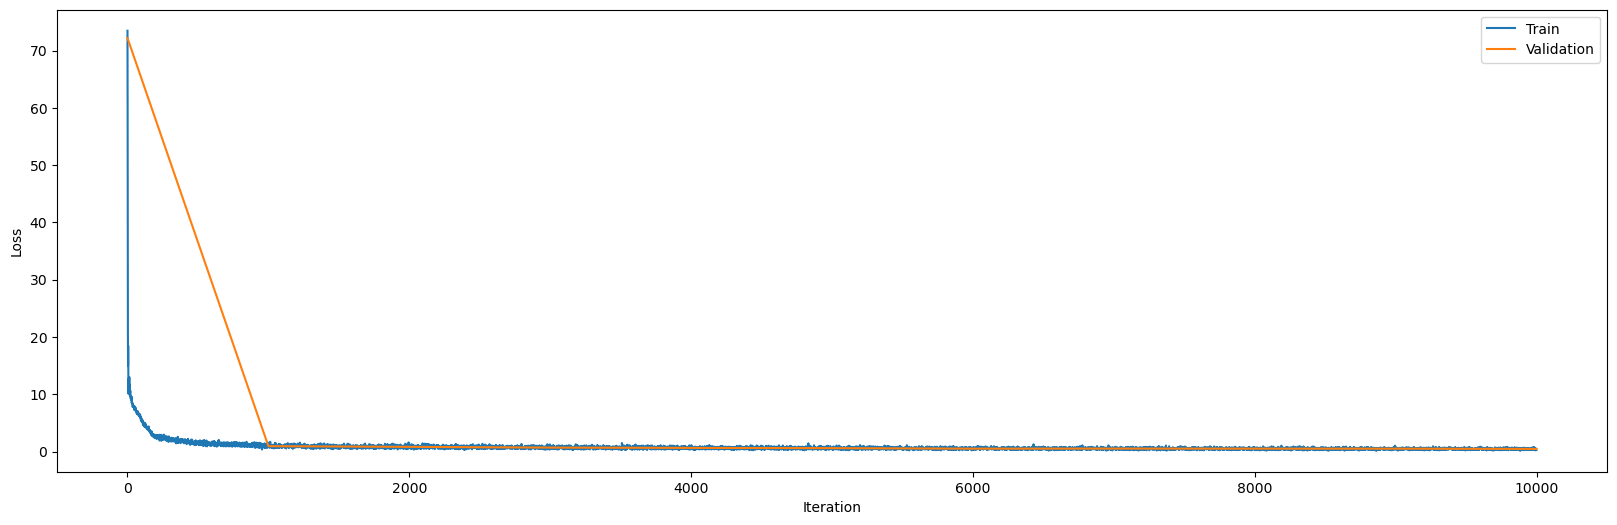

In [39]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

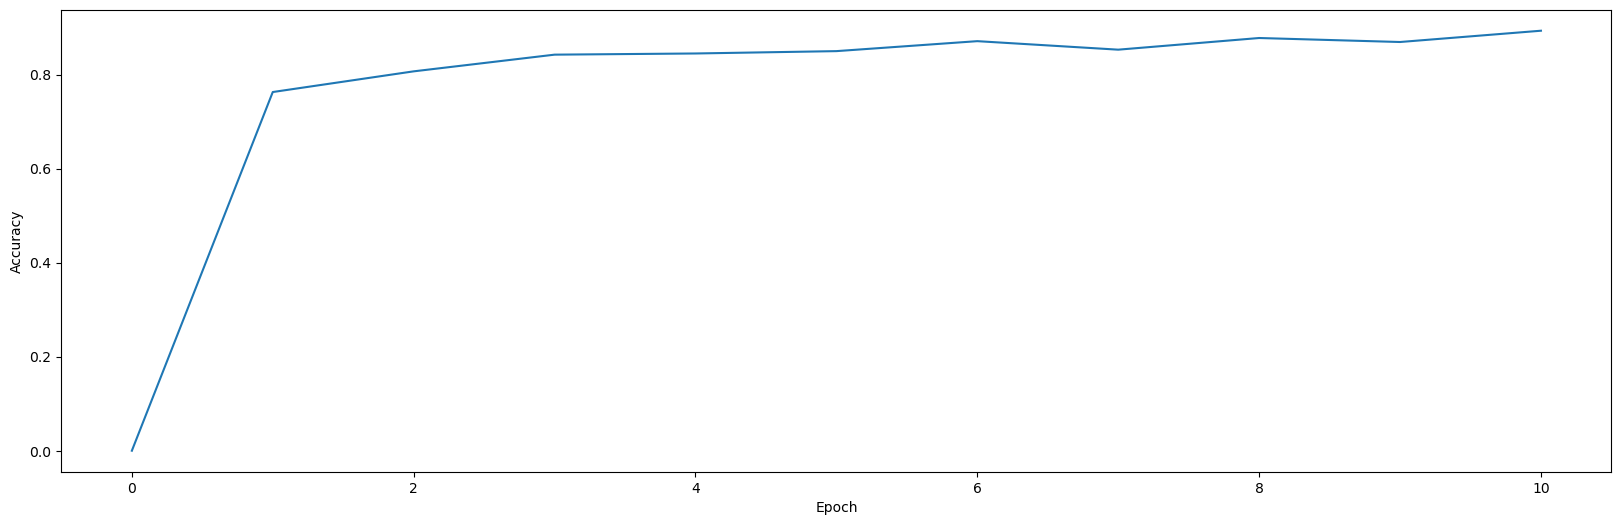

In [40]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Analysing cell-by-cell:
Test Set Loss: 0.45988408267498015
Test Set Accuracy: 99.08%
Analysing event-per-event:
Test Set Loss: 0.4598840855062008
Test Set Accuracy: 89.18%
F1 score: 0.9708002209663391


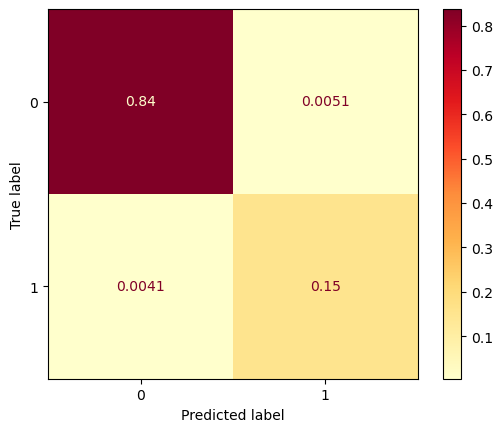

In [71]:
mean_loss_test, acc_test, cm = accuracy_set(net_2, test_loader, loss_fn, 'cell', timesteps, 0,
                                            batch_size, True, False, True, False, None)
print("Analysing cell-by-cell:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test, _ = accuracy_set(net_2, test_loader, loss_fn, 'cell_per_evt', timesteps, 0,
                                           batch_size, False, False, True, False, None)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

f1 = F1_score(cm)
print(f"F1 score: {f1}")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot(cmap='YlOrRd')

Convolutional:

In [42]:
filters = [100, 40, 16]
pad = 16
alpha_exp = 0.67723

net_2conv = CNN_LIF_3CL_MP(filters, num_inputs, num_hidden, num_output, timesteps+pad, learnable, beta, threshold).to(device)

In [43]:
optimizer = torch.optim.Adam(net_2conv.parameters(), lr=2e-3, betas=(0.9, 0.999))
num_epochs = 10

loss_hist, loss_val_hist, acc_val_hist = train_net(net_2conv,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, pad, batch_size,
                                                   False, False, False, alpha_exp)

torch.save(net_2conv.state_dict(), "results/Optimal/net_2conv")

Validation Set Loss: 11.090357780456543
Validation Set Accuracy: 30.32%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 11.090357780456543 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 7.7451677322387695 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 3.114046096801758 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 2.748473644256592 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 1.472837209701538 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 1.4075896739959717 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 1.036303162574768 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 1.0686085224151611 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 0.9429919719696045 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 1.1681941747665405 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 1.187301516532898 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 0.8292917013168335 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 0.9181579351425171 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 0.9214959740638733 

Epoch: 1
Batch: 70

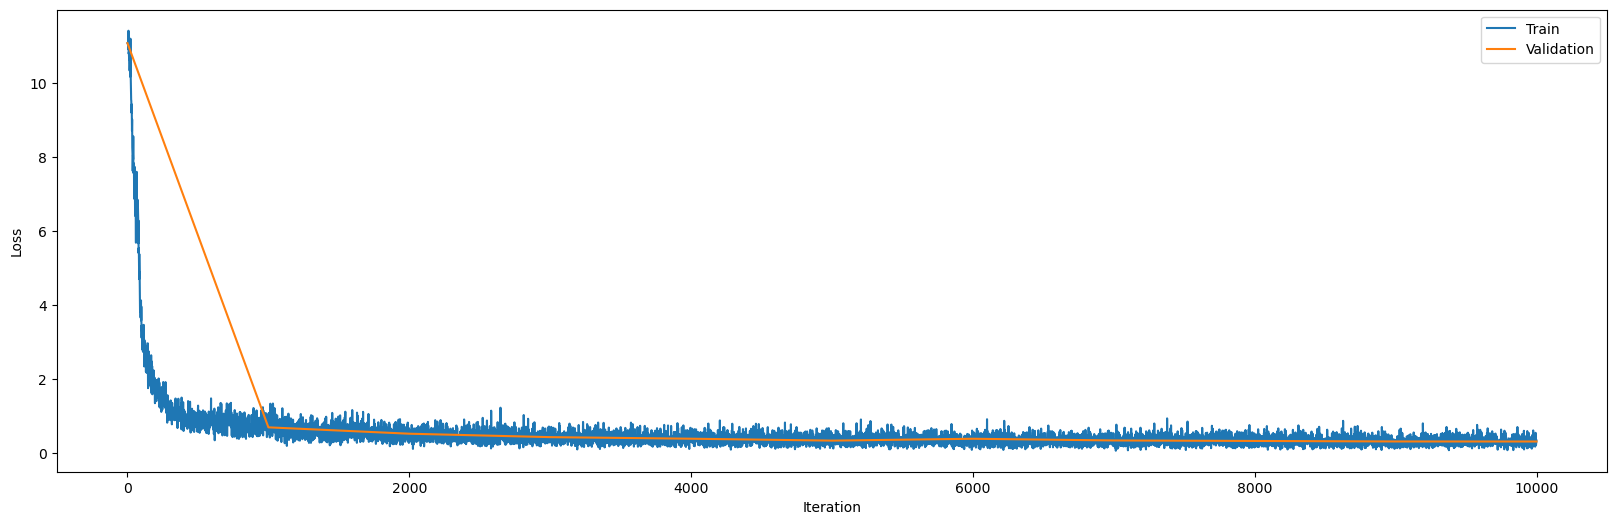

In [44]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

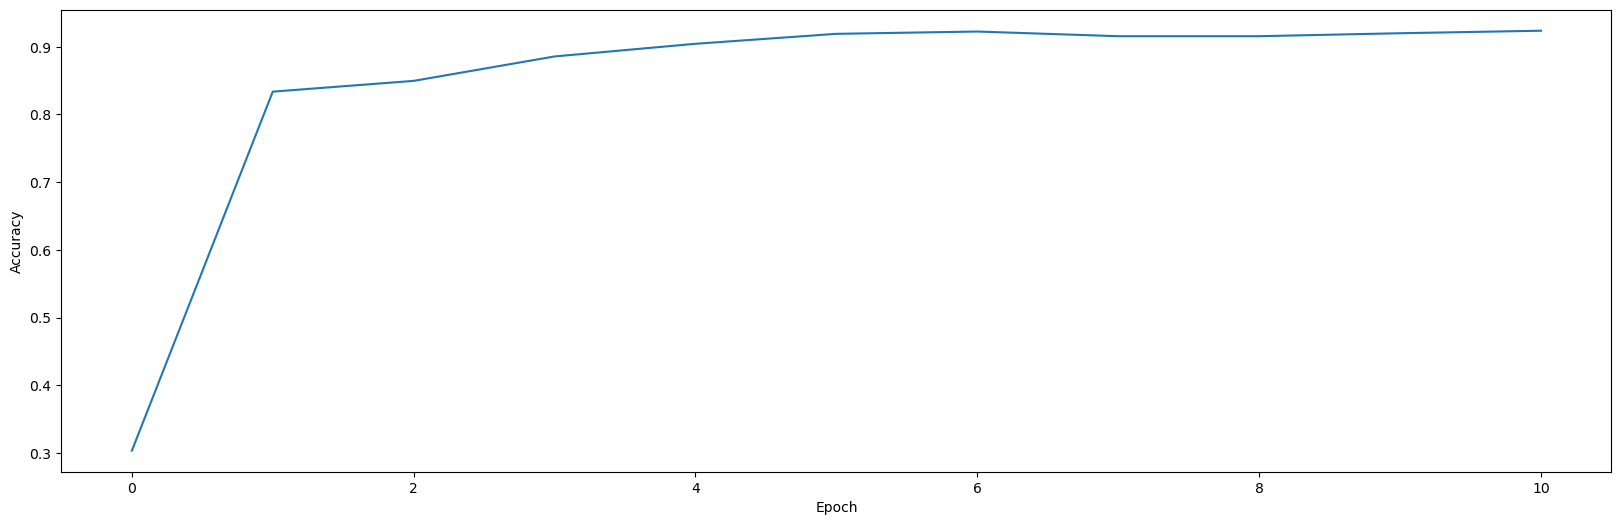

In [45]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Analysing cell-by-cell:
Test Set Loss: 0.32189042076468466
Test Set Accuracy: 99.32%
Analysing event-per-event:
Test Set Loss: 0.32189042508602145
Test Set Accuracy: 92.25%
F1 score: 0.9786081910133362


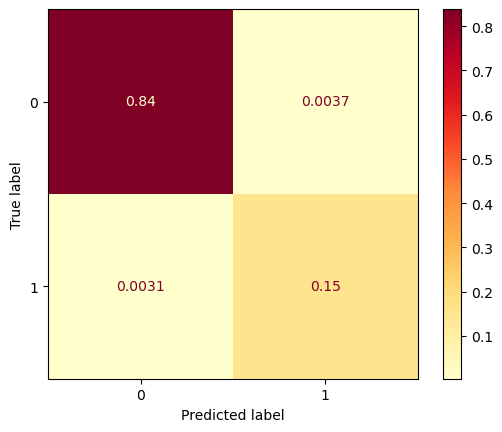

In [72]:
mean_loss_test, acc_test, cm = accuracy_set(net_2conv, test_loader, loss_fn, 'cell', timesteps, pad,
                                            batch_size, True, False, False, False, alpha_exp)
print("Analysing cell-by-cell:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test, _ = accuracy_set(net_2conv, test_loader, loss_fn, 'cell_per_evt', timesteps, pad,
                                           batch_size, False, False, False, False, alpha_exp)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

f1 = F1_score(cm)
print(f"F1 score: {f1}")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot(cmap='YlOrRd')

### Precise Timing

In [47]:
target      = gen_target_timing(muon_list,      size=max_n,      target_dtype=np.float32, features=feature_list)
target_test = gen_target_timing(muon_list_test, size=max_n_test, target_dtype=np.float32, features=feature_list)
target_val  = gen_target_timing(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [48]:
train_dataset = CustomDataset(mu_arr,      target,      transform=transform)
test_dataset  = CustomDataset(mu_arr_test, target_test, transform=transform)
val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=nw)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True, num_workers=nw)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=True, num_workers=nw)

BCEMR Loss:

In [52]:
num_inputs = 16
num_hidden = 100
num_output = 16
timesteps  = 40
learnable  = True
beta       = 0.8
threshold  = 1.0
alpha      = 0.8

net_3 = Net_Syn_1L(num_inputs, num_hidden, num_output, timesteps, learnable, beta, threshold, alpha).to(device)

In [53]:
loss_fn = bce_mem_loss_timing()
accuracy_type = 'bce_timing_per_evt'
optimizer = torch.optim.Adam(net_3.parameters(), lr=5e-4, betas=(0.9, 0.999))
num_epochs = 5

loss_hist, loss_val_hist, acc_val_hist = train_net(net_3,
                                                   train_loader, val_loader,
                                                   num_epochs, loss_fn, optimizer,
                                                   accuracy_type, timesteps, 0, batch_size,
                                                   True, True, True, None)

torch.save(net_3.state_dict(), "results/Optimal/net_3")

Validation Set Loss: 0.7257328033447266
Validation Set Accuracy: 0.00%

--------------------------------------------------

Epoch: 1
Batch: 0
Iteration: 0
Loss: 0.7254757285118103 

Epoch: 1
Batch: 50
Iteration: 50
Loss: 0.12007726728916168 

Epoch: 1
Batch: 100
Iteration: 100
Loss: 0.10934267193078995 

Epoch: 1
Batch: 150
Iteration: 150
Loss: 0.1036093458533287 

Epoch: 1
Batch: 200
Iteration: 200
Loss: 0.09980511665344238 

Epoch: 1
Batch: 250
Iteration: 250
Loss: 0.09348029643297195 

Epoch: 1
Batch: 300
Iteration: 300
Loss: 0.08949151635169983 

Epoch: 1
Batch: 350
Iteration: 350
Loss: 0.08877217024564743 

Epoch: 1
Batch: 400
Iteration: 400
Loss: 0.08565020561218262 

Epoch: 1
Batch: 450
Iteration: 450
Loss: 0.08301981538534164 

Epoch: 1
Batch: 500
Iteration: 500
Loss: 0.07859065383672714 

Epoch: 1
Batch: 550
Iteration: 550
Loss: 0.0784594714641571 

Epoch: 1
Batch: 600
Iteration: 600
Loss: 0.07800804078578949 

Epoch: 1
Batch: 650
Iteration: 650
Loss: 0.0729365348815918 

Epoc

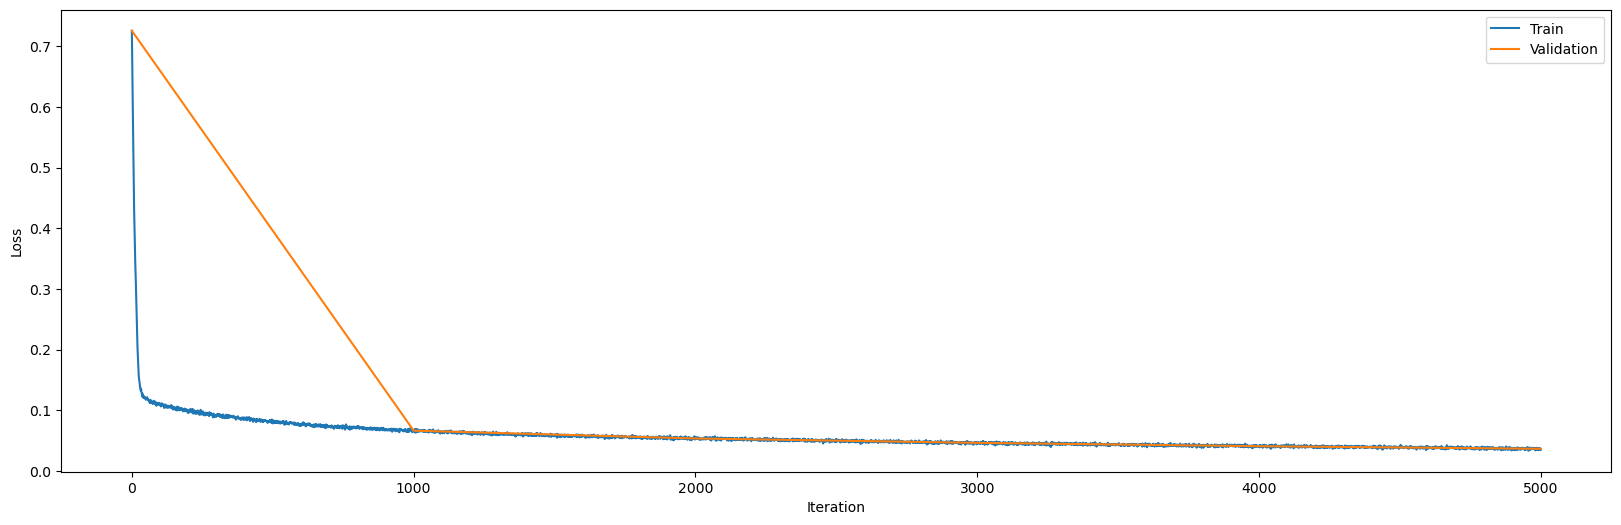

In [54]:
# Plot Loss
fig = plt.figure(facecolor="w", figsize=(20, 6))
x1 = np.arange(n_evt/batch_size*num_epochs)
x2 = np.arange(0, n_evt/batch_size*num_epochs+1, n_evt/batch_size)
plt.plot(x1, loss_hist,     label='Train')
plt.plot(x2, loss_val_hist, label='Validation')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

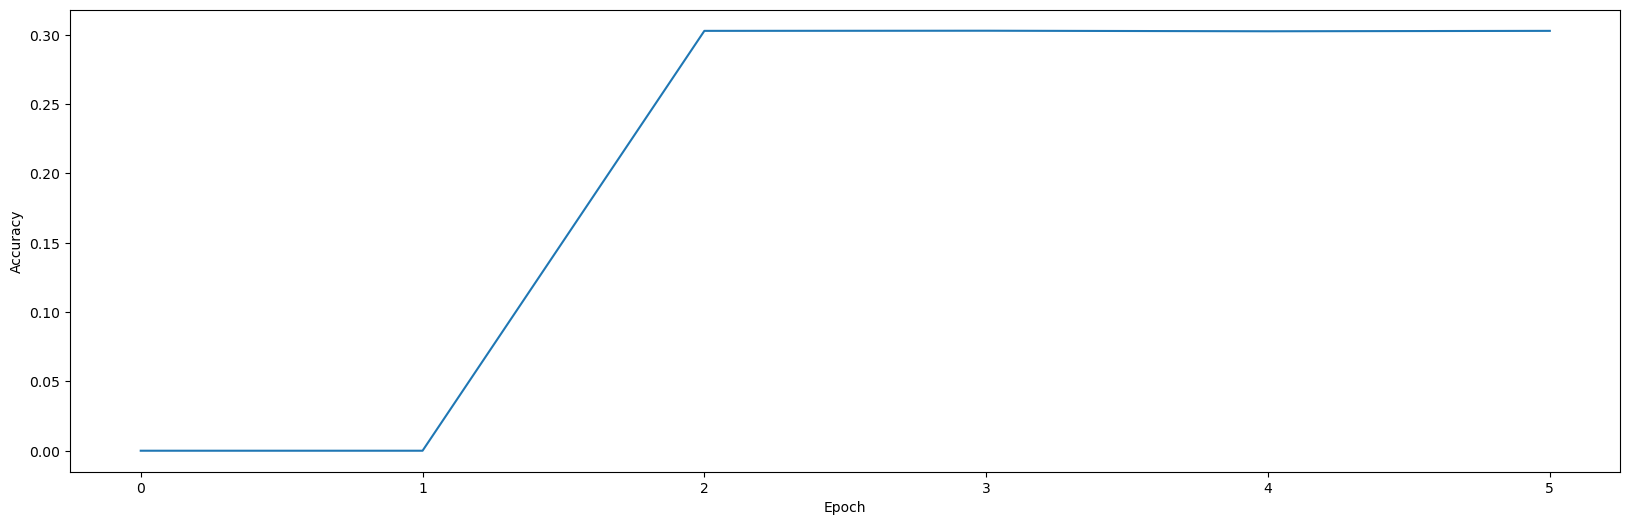

In [55]:
# Plot accuracy
fig = plt.figure(facecolor="w", figsize=(20, 6))
plt.plot(acc_val_hist,  label='Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

Analysing cell-by-cell and moment-by-moment:
Test Set Loss: 0.03680910434573889
Test Set Accuracy: 99.60%
Analysing event-per-event:
Test Set Loss: 0.03680910348892212
Test Set Accuracy: 30.42%
F1 score: 0.0005525733577087522


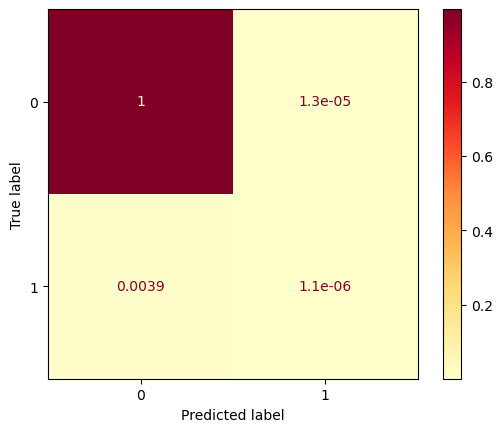

In [56]:
mean_loss_test, acc_test, cm = accuracy_set(net_3, test_loader, loss_fn, 'bce_timing',
                                            timesteps, 0 ,batch_size, True, True, True, True, None)
print("Analysing cell-by-cell and moment-by-moment:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

mean_loss_test, acc_test, _ = accuracy_set(net_3, test_loader, loss_fn, 'bce_timing_per_evt',
                                           timesteps, 0, batch_size, False, True, True, True, None)
print("Analysing event-per-event:")
print(f"Test Set Loss: {mean_loss_test}")
print(f"Test Set Accuracy: {100 *acc_test:.2f}%")

f1 = F1_score(cm)
print(f"F1 score: {f1}")

ConfusionMatrixDisplay(confusion_matrix=cm.numpy()).plot(cmap='YlOrRd')